# Model testing, metrics

In [26]:
import os
import context
import loader 
from loader import guide_function
import numpy as np
from matplotlib import pyplot as plt
from harmonic import cluster
from harmonic.unet import UNet,eUNet, nUNet, aUNet
from harmonic.sq_unet import UNet as USN
from harmonic.unet import bUNet
from harmonic.embeddings import *
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Import data

In [9]:
HeLa_9 = loader.hela('data/HeLa_01_ST/HeLaTrain',test=True)
plants = loader.cvppp('data/A1',test=True)

In [14]:
c = HeLa_9
# HELA
train_data = loader.Reader(c.rgb, c.labels, c.edges, 
                           c.transform, c.transform_target,loader=loader.gray_loader,
                            targ_loader = True)
# CVPPP 
train_data = loader.Reader(c.rgb, c.labels, c.edges, 
                           c.transform, c.transform_target)
generator = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)

## 1.1 Load Harmonics

## HeLa

###  Sine functions 

In [29]:
sins = [[-7.375255107879639, 5.203563690185547, 45.27313232421875],
 [-7.378573417663574, -1.9893327951431274, 20.848262786865234],
 [-7.0850653648376465, -2.456326961517334, 41.53719711303711],
 [11.45650577545166, -2.489238739013672, 31.25278091430664],
 [-1.703177571296692, -6.168859958648682, 5.964511394500732],
 [11.166621208190918, 5.2173919677734375, 38.755393981933594],
 [-0.6013728380203247, 12.734735488891602, 3.7188491821289062],
 [6.044683933258057, 12.558919906616211, 52.94304656982422],
 [5.92817497253418, -0.7977170944213867, 54.80228805541992],
 [-0.38155657052993774, 23.551265716552734, 35.34095001220703],
 [1.972337245941162, 5.383609294891357, 46.41643524169922],
 [4.012279033660889, -4.179959774017334, 35.26789093017578]]

sins = np.array(sins)
guides = guide_function(sins[:,0],sins[:,1],sins[:,2],448,448)

### Square harmonics

In [111]:
from sq_embeddings import Embedding as Embsquare
sins = [[-13.559544563293457,
  -2.203810453414917,
  21.30968475341797,
  0.9219708442687988],
 [-22.703413009643555,
  -0.37252742052078247,
  10.278214454650879,
  0.999194860458374],
 [6.941484451293945,
  -2.721510410308838,
  44.56106948852539,
  0.9472301602363586],
 [7.547652721405029, 0.9692023992538452, 39.369895935058594, 1.0],
 [-14.903787612915039,
  -1.0364874601364136,
  4.260854721069336,
  0.9993869066238403],
 [-2.7566463947296143,
  4.760617256164551,
  5.812931060791016,
  0.9590798020362854],
 [1.0290216207504272, 5.537593841552734, 15.82655143737793, 1.0],
 [-0.4228498339653015,
  -12.698473930358887,
  8.141501426696777,
  0.9982108473777771],
 [0.3880113661289215, -13.395278930664062, 4.083737373352051, 1.0],
 [6.361560344696045, -6.721468925476074, 47.4748649597168, 0.4803535044193268],
 [-0.31598857045173645,
  24.429262161254883,
  22.79106903076172,
  0.9727568030357361],
 [3.190713405609131, 5.624609470367432, 21.73563003540039, 0.9920406937599182]]

emb2 = Embsquare(sins,[448, 448])
input = torch.zeros(1,1,448,448)

guides = []
for i in range(12):
    guides.append(emb2.sins[i].generate_xy(input).detach().squeeze(0).squeeze(0).numpy())
guides = torch.tensor(np.array(guides))

## CVPPP

### Load Harmonics

In [139]:
sins = [[-24.22295570373535, 0.0, 0.4452361464500427],
 [-14.779047012329102, 0.0, 1.2561423778533936],
 [-16.399198532104492, 0.0, -0.3734317719936371],
 [18.362571716308594, 0.0, 0.7659217715263367],
 [-0.6603534817695618, 0.0, 0.24005144834518433],
 [-33.7341423034668, 0.0, -0.4350433051586151],
 [0.0, 4.286965370178223, 0.8109257817268372],
 [0.0, -19.908288955688477, 0.614355206489563],
 [0.0, 22.987812042236328, 0.28104516863822937],
 [0.0, 7.108828067779541, 0.4827950894832611],
 [0.0, 23.66850471496582, 0.21264752745628357],
 [0.0, -22.332250595092773, 1.0007625818252563]]

sins = np.array(sins)
guides = guide_function(sins[:,0],sins[:,1],sins[:,2],448,448)

# 2. Load Model

In [18]:
bpath = 'models/hela'

a) No weighted loss

In [20]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_base0_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_base0_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errors0 = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


b) Edge width of 5 (same as Harmonic Embbeddings)

In [21]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_base3_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_base3_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errors5 = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


a) Edge width of 10

In [25]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_base10_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_base10_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errors10 = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


In [23]:
net = aUNet(1, sins).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists(bpath + '_basew_ckp0.t7'):
    print('Loading')
    data = torch.load(bpath + '_basew_ckp0.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])
    errorsw = data['error']
    net.eval()
    print("Model loaded.")

Loading
Model loaded.


# Plant Phenotyping

In [138]:
bpath = 'models/cvppp'

### Load Model

In [140]:
net = torch.nn.DataParallel(UNet(3, sins), [0]).to(device)
optim = torch.optim.Adam(net.parameters(),lr=1e-5)
embedder = EmbedderFast(guides.to(device),weights_norm=log_weights_norm(10.))

if os.path.exists('cvppp' + '_ckp3.t7'):
    print('Loading')
    data = torch.load('cvppp' + '_ckp3.t7',map_location=torch.device('cpu'))
    net.load_state_dict(data['model_state_dict'])#,strict=False)
    optim.load_state_dict(data['optimizer_state_dict'])

net.eval()
print("Model loaded")

Loading
Model loaded


Custom Pretraining 

In [86]:
trained_dict = data['model_state_dict']
# Using items() + list comprehension
# Substring Key match in dictionary
res = dict(filter(lambda item: 'module.down' not in item[0], trained_dict.items()))
res = dict(filter(lambda item: 'module.outc' not in item[0], res.items()))

# 3. Testing Protocol

### 1. Data generator

In [125]:
HeLa_test = loader.hela('data/HeLa_01_ST/HeLaTest',test=True)
c = HeLa_test
test_data = loader.Reader(c.rgb, c.labels, c.edges, 
                           c.transform, c.transform_target,loader=loader.gray_loader)
generator = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

### 2. Metrics

In [126]:
bdscore = []
ious = []
dic = []
for x,y,z in generator:
    emb = net(x.to(device)).detach().cpu().numpy()
    cc = cluster(emb[0],0.6,minimal_area=1000)
    
    xx = np.array(cc,dtype='int')
    yy = y.squeeze(0).squeeze(0).int().numpy()
    
    bdscore.append(accuracy(xx,yy,Dice))
    ious.append(accuracy(xx,yy,IOU))
    dic.append(DiC(xx,yy))
print('Done')

Done


In [351]:
base_weight = {'BDC' : 0.8000,
          'IOU':0.7160,
            'DiC':1.1111} ## MR 

base_5 = {'BDC' : 0.7648,
          'IOU':0.6852,
            'DiC':1.6666} ## MR 

base_10 = {'BDC' : 0.7449,
          'IOU':0.6506,
            'DiC':2.0} ## MR 

base_0 = {'BDC' : 0.741,
          'IOU':0.661,
            'DiC':1.7777} ## MR

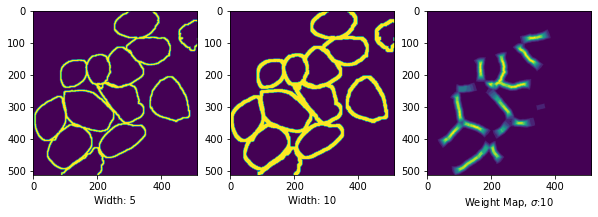

In [134]:
plt.figure(figsize=[10,5])
img1 = Image.open('data/HeLa_01_ST/HeLaTrain/edges5/031_edge.png')
img2 = Image.open('data/HeLa_01_ST/HeLaTrain/edges10/031_edge.png')
img3 = Image.open(HeLa_9.edges[3])
plt.subplot(131)
plt.imshow(img1)#,cmap='gray')
plt.xlabel('Width: 5')
plt.subplot(132)
plt.imshow(img2)#,cmap='gray')
plt.xlabel('Width: 10')
plt.subplot(133)
plt.imshow(img3)#,cmap='gray')
plt.xlabel('Weight Map, $\sigma$:10')
plt.savefig('Report/img/borders.png',format='png')

### Pixel Areas of the Maps 

In [169]:
from os import listdir
from os.path import join
import PIL.Image as Image

map_5 = 'data/HeLa_01_ST/HeLaTrain/edges5'
map_10 =  'data/HeLa_01_ST/HeLaTrain/edges10'
map_w =  'data/HeLa_01_ST/HeLaTrain/edgesw'

map_5 = sorted([join(map_5, f) for f in 
                   listdir(map_5) if f.endswith('png')])
map_10 = sorted([join(map_10, f) for f in 
                   listdir(map_10) if f.endswith('png')])
map_w = sorted([join(map_w, f) for f in 
                   listdir(map_w) if f.endswith('png')])

In [170]:
m5 = []
m10 = []
mw = []

for pic in map_5:
    img = np.array(Image.open(pic)).flatten()
    img =  1- (len(img[img == 0]))/len(img)
    m5.append(img)

m5 = np.array(m5)

for pic in map_10:
    img = np.array(Image.open(pic)).flatten()
    img =  1- (len(img[img == 0]))/len(img)
    m10.append(img)

m10 = np.array(m10)

for pic in map_w:
    img = np.array(Image.open(pic)).flatten()
    img =  1- (len(img[img == 0]))/len(img)
    mw.append(img)

mw = np.array(mw)

its = np.array([it for it in [m5,mw,m10]])
means = [np.mean(it) for it in [m5,mw,m10]]
sd = [np.std(it) for it in [m5,mw,m10]]

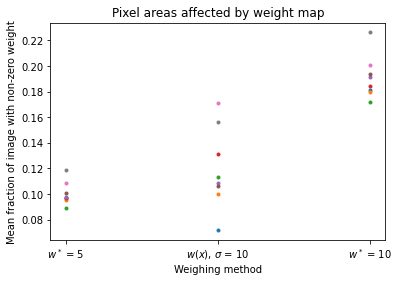

In [174]:
#plt.errorbar(['$w^*$ = 5', '$w(x)$, $\sigma$ = 10', '$w^*$ = 10'],
         #    means,sd,linestyle='None', marker='^')
plt.plot(['$w^*$ = 5', '$w(x)$, $\sigma$ = 10', '$w^*$ = 10'],its,'.')
plt.title('Pixel areas affected by weight map')
plt.ylabel('Mean fraction of image with non-zero weight')
plt.xlabel('Weighing method')
plt.savefig('Report/img/weights.png',format='png')